In [1]:
#상태유지 스택 순환신경망
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.keras.backend.clear_session()

from keras.utils import np_utils

import pandas as pd
from sklearn import datasets
from keras.backend import tensorflow_backend as K
from keras import regularizers
import os
from keras import backend as K
import matplotlib.pyplot as plt
import glob


from pandas import DataFrame   
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, Dropout
from math import sqrt
from matplotlib import pyplot
from numpy import array
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
#	print("names: ",names)
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
#	print("names2: ", names)
	# put it all together
	agg = concat(cols, axis=1)
#	print("agg: ", agg)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# create a differenced series / 데이터를 정지하게 하는 기능
def difference(dataset, interval=1):
	diff = list() #빈 리스트 생성 -> 간격만큼 뺀 값들, 작업하기 더 간단한 표현
	for i in range(interval, len(dataset)): #1부터 데이터셋 길이만큼 반복
		value = dataset[i] - dataset[i - interval]
		#print("diffenece()의 value: ", value, "/ dataset[i]-dataset[i-interval]: ",dataset[i]," / ", dataset[i - interval] )
		diff.append(value)
	return Series(diff)
 
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
    
	# rescale values to -1, 1 - 정규화 minmax
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
    #scaled_values: 차이만큼 뺴고 정규화한 값을 지도핛ㅂ
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test
 
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2])
                 , return_sequences=True,stateful=True, recurrent_dropout=0.2))
#	model.add(Dropout(0.15))
	model.add(LSTM(90, return_sequences=True, stateful=True, recurrent_dropout=0.2))
#	model.add(Dropout(0.15))
	model.add(Bidirectional(LSTM(60, return_sequences = False)))
	model.add(Dense(y.shape[1]))
    
	model.compile(loss='mse', optimizer='RMSprop')
	print(model.summary())
	# fit network
	for i in range(nb_epoch):
		print("Total epoch: %d / %d" % (i+1,nb_epoch))
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
		model.reset_states()
	return model
 
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]
 
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts
 
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted
 
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted
 
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
 
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test, y):
	# plot the entire dataset in blue
	plt.figure(figsize=(25,5))
	plt.xticks(np.arange(0,series.shape[0],step=500),series.index, rotation=90)
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		plt.axhline(y=y, xmin=0.02, xmax=0.98, color='red')
		pyplot.plot(xaxis, yaxis, color='orange')
	# show the plot
pyplot.show()
 

Using TensorFlow backend.
C:\Users\yu\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [2]:
files1 = glob.glob(os.path.join('../', '*.csv'))
#files = os.path.listdir('./')
#train = pd.DataFrame()
#xy = pd.DataFrame()

li = []
print(len(files1))
for file in range(len(files1)-1300):
    df = pd.read_csv(files1[file], error_bad_lines=False, header=0, index_col=False, usecols=[*range(0, 198)],
        names=["DATE","EA1","EA2","EA3","EA4","EA5","EA6","EA7","EA8","EA9","EA10","EA11","EA12","EA13","EA14","EA15","EA16","EA17","EA18","EA19","EA20","EA21","EA22","EA23","EA24","EA25","EA26","EA27","EA28","EA29","EA30","EA31","EA32","EA33","EA34","EA35","EA36","EA37","EA38","EA39","EA40","EA41","EA42","EA43","EA44","EA45","EA46","EA47","EA48","EA49","EA50","EA51","EA52","EA53","EA54","EA55","EA56","EA57","EA58","EA59","EA60","EA61","EA62","EA63","EA64","EA65","EA66","EA67","EA68","EA69","EA70","EA71","EA72","EA73","EA74","EA75","EA76","EA77","EA78","EA79","EA80","EA81","EA82","EA83","EA84","EA85","EA86","EA87","EA88","EA89","EA90","EA91","EA92","EA93","EA94","EA95","EA96","EA97","EA98","EA99","EA100","EA101","EA102","EA103","EA104","EA105","EA106","EA107","EA108","EA109","EA110","EA111","EA112","EA113","EA114","EA115","EA116","EA117","EA118","EA119","EA120","EA121","EA122","EA123","EA124","EA125","EA126","EA127","EA128","EA129","EA130","EA131","EA132","EA133","EA134","EA135","EA136","EA137","EA138","EA139","EA140","EA141","EA142","EA143","EA144","EA145","EA146","EA147","EA148","EA149","EA150","EA151","EA152","EA153","EA154","EA155","EA156","EA157","EA158","EA159","EA160","EA161","EA162","EA163","EA164","EA165","EA166","EA167","EA168","EA169","EA170","EA171","EA172","EA173","EA174","EA175","EA176","EA177","EA178","EA179","EA180","EA181","EA182","EA183","EA184","EA185","EA186","EA187","EA188","EA189","EA190","EA191","EA192","EA193","EA194","EA195","EA196","EA197","ED1","ED2","ED3","ED4","ED5","ED6","ED7","ED8","ED9","ED10","ED11","ED12","ED13","ED14","ED15","ED16","ED17","ED18","ED19","ED20","ED21","ED22","ED23","ED24","ED25","ED26","ED27","ED28","ED29","ED30","ED31","ED32","ED33","ED34","ED35","ED36","ED37","ED38","ED39","ED40","ED41","ED42","ED43","ED44","ED45","ED46","ED47","ED48","ED49","ED50","ED51","ED52","ED53","ED54","ED55","ED56","ED57","ED58","ED59","ED60","ED61","ED62","ED63","ED64","ED65","ED66","ED67","ED68","ED69","ED70","ED71","ED72","ED73","ED74","ED75","ED76","ED77","ED78","ED79","ED80","ED81","ED82","ED83","ED84","ED85","ED86","ED87","ED88","ED89","ED90","ED91","ED92","ED93","ED94","ED95","ED96","ED97","ED98","ED99","ED100","ED101","ED102","ED103","ED104","ED105","ED106","ED107","ED108","ED109","ED110","ED111","ED112","ED113","ED114","ED115","ED116","ED117","ED118","ED119","ED120","ED121","ED122","ED123","ED124","ED125","ED126","ED127","ED128","ED129","ED130","ED131","ED132","ED133","ED134","ED135","ED136","ED137","ED138","ED139","ED140","ED141","ED142","ED143","ED144","ED145","ED146","ED147","ED148","ED149","ED150","ED151","ED152","ED153","ED154","ED155","ED156","ED157","ED158","ED159","ED160","ED161","ED162","ED163","ED164","ED165","ED166","ED167","ED168","ED169","ED170","ED171","ED172","ED173","ED174","ED175","ED176","ED177","ED178","ED179","ED180","ED181","ED182","ED183","ED184","ED185","ED186","ED187","ED188","ED189","ED190","ED191","ED192","ED193","ED194","ED195","ED196","ED197","ED198","ED199","ED200","ED201","ED202","ED203","ED204","ED205","ED206","ED207","ED208","ED209","ED210","ED211","ED212","ED213","ED214","ED215","ED216","ED217","ED218","ED219","ED220","ED221","ED222","ED223","ED224","ED225","ED226","ED227","ED228","ED229","ED230","ED231","ED232","ED233","ED234","ED235","ED236","ED237","ED238","ED239","ED240","ED241","ED242","ED243","ED244","ED245","ED246","ED247","ED248","ED249","ED250","ED251","ED252","ED253","ED254","ED255","ED256","ED257","ED258","ED259","ED260","ED261","ED262","ED263","ED264","ED265","ED266","ED267","ED268","ED269","ED270","ED271","ED272","ED273","ED274","ED275","ED276","ED277","ED278","ED279","ED280","ED281","ED282","ED283","ED284","ED285","ED286","ED287","ED288","ED289","ED290","ED291","ED292","ED293","ED294","ED295","ED296","ED297","ED298","ED299","ED300","ED301","ED302","ED303","ED304","ED305","ED306","ED307","ED308","ED309","ED310","ED311","ED312","ED313","ED314","ED315","ED316","ED317","ED318","ED319","ED320","ED321","ED322","ED323","ED324","ED325","ED326","ED327","ED328","ED329","ED330","ED331","ED332","ED333","ED334","ED335","ED336","ED337","ED338","ED339","ED340","ED341","ED342","ED343","ED344","ED345","ED346","ED347","ED348","ED349","ED350","ED351","ED352","ED353","ED354","ED355","ED356","ED357","ED358","ED359","ED360","ED361","ED362","ED363","ED364","ED365","ED366","ED367","ED368","ED369","ED370","ED371","ED372","ED373","ED374","ED375","ED376","ED377","ED378","ED379","ED380","ED381","ED382","ED383","ED384","ED385","ED386","ED387","ED388","ED389","ED390","ED391","ED392","ED393","ED394","ED395","ED396","ED397","ED398","ED399","ED400","ED401","ED402","ED403","ED404","ED405","ED406","ED407","ED408","ED409","ED410","ED411","ED412","ED413","ED414","ED415","ED416","ED417","ED418","ED419","ED420","ED421","ED422","ED423","ED424","ED425","ED426","ED427","ED428","ED429","ED430","ED431","ED432","ED433","ED434","ED435","ED436","ED437","ED438","ED439","ED440","ED441","ED442","ED443","ED444","ED445","ED446","ED447","ED448","ED449","ED450","ED451","ED452","ED453","ED454","ED455","ED456","ED457","ED458","ED459","ED460","ED461","ED462","ED463","ED464","ED465","ED466","ED467","ED468","ED469","ED470","ED471","ED472","ED473","ED474","ED475","ED476","ED477","ED478","ED479","ED480","ED481","ED482","ED483","ED484","ED485","ED486","ED487","ED488","ED489","ED490","ED491","ED492","ED493","ED494","ED495","ED496","ED497","ED498","ED499","ED500","ED501","ED502","ED503","ED504","ED505","ED506","ED507","ED508","ED509","ED510","ED511","ED512","ED513","ED514","ED515","ED516","ED517","ED518","ED519","ED520","ED521","ED522","ED523","ED524","ED525","ED526","ED527","ED528","ED529","ED530","ED531","ED532","ED533","ED534","ED535","ED536","ED537","ED538","ED539","ED540","ED541","ED542","ED543","ED544","ED545","ED546","ED547","ED548","ED549","ED550","ED551","ED552","ED553","ED554","ED555","ED556","ED557","ED558","ED559","ED560","ED561","ED562","ED563","ED564","ED565","ED566","ED567","ED568","ED569","ED570","ED571","ED572","ED573","ED574","ED575","ED576","ED577","ED578","ED579","ED580","ED581","ED582","ED583","ED584","ED585","ED586","ED587","ED588","ED589","ED590","ED591","ED592","ED593","ED594","ED595","ED596","ED597","ED598","ED599","ED600","ED601","ED602","ED603","ED604","ED605","ED606","ED607","ED608","ED609","ED610","ED611","ED612","ED613","ED614","ED615","ED616","ED617","ED618","ED619","ED620","ED621","ED622","ED623","ED624","ED625","ED626","ED627","ED628","ED629","ED630","ED631","ED632","ED633","ED634","ED635","ED636","ED637","ED638","ED639","ED640","ED641","ED642","ED643","ED644","ED645","ED646","ED647","ED648","ED649","ED650","ED651","ED652","ED653","ED654","ED655","ED656","ED657","ED658","ED659","ED660","ED661","ED662","ED663","ED664","ED665","ED666","ED667","ED668","ED669","ED670","ED671","ED672","ED673","ED674","ED675","ED676","ED677","ED678","ED679","ED680","ED681","ED682","ED683","ED684","ED685","ED686","ED687","ED688","ED689","ED690","ED691","ED692","ED693","ED694","ED695","ED696","ED697","ED698","ED699","ED700","ED701","ED702","ED703","ED704","ED705","ED706","ED707","ED708","ED709","ED710","ED711","ED712","ED713","ED714","ED715","ED716","ED717","ED718","ED719","ED720","ED721","ED722","ED723","ED724","ED725","ED726","ED727","ED728","ED729","ED730","ED731","ED732","ED733","ED734","ED735","ED736","ED737","ED738","ED739","ED740","ED741","ED742","ED743","ED744","ED745","ED746","ED747","ED748","ED749","ED750","ED751","ED752","ED753","ED754","ED755","ED756","ED757","ED758","ED759","ED760","ED761","ED762","ED763","ED764","ED765","ED766","ED767","ED768","ED769","ED770","ED771","ED772","ED773","ED774","ED775","ED776","ED777","ED778","ED779","ED780","ED781","ED782","ED783","ED784","ED785","ED786","ED787","ED788","ED789","ED790","ED791","ED792","ED793","ED794","ED795","ED796","ED797","ED798","ED799","ED800","ED801","ED802","ED803","ED804","ED805","ED806","ED807","ED808","ED809","ED810","ED811","ED812","ED813","ED814","ED815","ED816","ED817","ED818","ED819","ED820","ED821","ED822","ED823","ED824","ED825","ED826","ED827","ED828","ED829","ED830","ED831","ED832","ED833","ED834","ED835","ED836","ED837","ED838","ED839","ED840","ED841","ED842","ED843","ED844","ED845","ED846","ED847","ED848","ED849","ED850","ED851","ED852","ED853","ED854","ED855","ED856","ED857","ED858","ED859","ED860","ED861","ED862","ED863","ED864","ED865","ED866","ED867","ED868","ED869","ED870","ED871","ED872","ED873","ED874","ED875","ED876","ED877","ED878","ED879","ED880","ED881","ED882","ED883","ED884","ED885","ED886","ED887","ED888","ED889","ED890","ED891","ED892","ED893","ED894","ED895","ED896","ED897","ED898","ED899","ED900","ED901","ED902","ED903","ED904","ED905","ED906","ED907","ED908","ED909","ED910","ED911","ED912","ED913","ED914","ED915","ED916","ED917","ED918","ED919","ED920","ED921","ED922","ED923","ED924","ED925","ED926","ED927","ED928","ED929","ED930","ED931","ED932","ED933","ED934","ED935","ED936","ED937","ED938","ED939","ED940","ED941","ED942","ED943","ED944","ED945","ED946","ED947","ED948","ED949","ED950","ED951","ED952","ED953","ED954","ED955","ED956","ED957","ED958","ED959","ED960","ED961","ED962","ED963","ED964","ED965","ED966","ED967","ED968","ED969","ED970","ED971","ED972","ED973","ED974","ED975","ED976","ED977","ED978","ED979","ED980","ED981","ED982","ED983","ED984","ED985","ED986","ED987","ED988","ED989","ED990","ED991","ED992","ED993","ED994","ED995","ED996","ED997","ED998","ED999","ED1000","ED1001","ED1002","ED1003","ED1004","ED1005","ED1006","ED1007","ED1008","ED1009","ED1010","ED1011","ED1012","ED1013","ED1014","ED1015","ED1016","ED1017","ED1018","ED1019","ED1020","ED1021","ED1022","ED1023","ED1024","ED1025","ED1026","ED1027","ED1028","ED1029","ED1030","ED1031","ED1032","ED1033","ED1034","ED1035","ED1036","ED1037","ED1038","ED1039","ED1040","ED1041","ED1042","ED1043","ED1044","ED1045","ED1046","ED1047","ED1048","ED1049","ED1050","ED1051","ED1052","ED1053","ED1054","ED1055","ED1056","ED1057","ED1058","ED1059","ED1060","ED1061","ED1062","ED1063","ED1064","ED1065","ED1066","ED1067","ED1068","ED1069","ED1070","ED1071","ED1072"]
        )   #오류나는 라인 생략, header=0: 1번째 행이 칼럼 이름
                    
    #print(df.columns)
    #print(df.head()
    li.append(df)
    print(files1[file])
#    else:
#        test.append(xy)

#print (li)
xy = pd.concat(li, axis=0, ignore_index=True)
xy

1428
..\Columbia_Axia_Termonorte_Engine02_2019_09_30_23_30_00.csv
..\Columbia_Axia_Termonorte_Engine02_2019_10_01_00_00_00.csv
..\Columbia_Axia_Termonorte_Engine02_2019_10_01_00_30_00.csv
..\Columbia_Axia_Termonorte_Engine02_2019_10_01_01_00_00.csv
..\Columbia_Axia_Termonorte_Engine02_2019_10_01_01_30_00.csv
..\Columbia_Axia_Termonorte_Engine02_2019_10_01_02_00_00.csv
..\Columbia_Axia_Termonorte_Engine02_2019_10_01_02_30_00.csv
..\Columbia_Axia_Termonorte_Engine02_2019_10_01_03_00_00.csv
..\Columbia_Axia_Termonorte_Engine02_2019_10_01_03_30_00.csv
..\Columbia_Axia_Termonorte_Engine02_2019_10_01_04_00_00.csv
..\Columbia_Axia_Termonorte_Engine02_2019_10_01_04_30_00.csv
..\Columbia_Axia_Termonorte_Engine02_2019_10_01_05_00_00.csv
..\Columbia_Axia_Termonorte_Engine02_2019_10_01_05_30_00.csv
..\Columbia_Axia_Termonorte_Engine02_2019_10_01_06_00_00.csv
..\Columbia_Axia_Termonorte_Engine02_2019_10_01_06_30_00.csv
..\Columbia_Axia_Termonorte_Engine02_2019_10_01_07_00_00.csv
..\Columbia_Axia_Te

,DATE,EA1,EA2,EA3,EA4,EA5,EA6,EA7,EA8,EA9,...,EA188,EA189,EA190,EA191,EA192,EA193,EA194,EA195,EA196,EA197
0,2019-09-30 23:30,81,86,86,88,86,86,86,86,88,...,96,78,92,85,84,1.1,1.0,32,15.7,11
1,2019-09-30 23:30,81,86,86,88,86,86,86,86,88,...,96,78,92,85,84,1.2,1.0,32,15.7,11
2,2019-09-30 23:30,81,86,86,88,86,86,86,86,88,...,96,78,92,85,84,1.1,1.0,32,15.7,11
3,2019-09-30 23:30,81,86,86,88,86,86,86,86,88,...,96,78,92,85,84,1.1,1.0,32,15.7,11
4,2019-09-30 23:30,81,86,86,88,86,86,86,86,88,...,96,78,92,85,84,1.1,1.0,32,15.7,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230395,2019-10-03 15:59:55,81,85,86,88,85,86,85,85,88,...,95,78,92,87,85,1.1,1.0,38,12.5,10
230396,2019-10-03 15:59:56,81,85,86,88,85,86,85,85,88,...,95,78,92,87,85,1.1,1.0,38,12.5,10
230397,2019-10-03 15:59:57,81,85,86,88,85,85,85,85,88,...,95,78,92,87,85,1.2,1.0,38,12.5,10
230398,2019-10-03 15:59:58,81,85,86,88,85,85,85,85,88,...,95,78,92,87,85,1.2,1.0,38,12.5,10


In [3]:
# 경고 표시
alert = 0

In [4]:
#Exh. Gas temp Cyl. A09 (TE25-A9)

print(xy)
#print(xy.shape)
#xy.columns
date = xy.iloc[15000:42000, 0:1].values
value = xy.iloc[15000:42000, 89:90].values

#print("컬럼명: ",xy.columns[89])

date = date.ravel()
value = value.ravel()


x1 = pd.DataFrame({xy.columns[89]: value},index=date)

#value = std_based_outlier(value)
#xy = MinMaxScaler(xy)
#xy = pd.DataFrame(list(xy))

x1

                       DATE  EA1  EA2  EA3  EA4  EA5  EA6  EA7  EA8  EA9  ...  \
0          2019-09-30 23:30   81   86   86   88   86   86   86   86   88  ...   
1          2019-09-30 23:30   81   86   86   88   86   86   86   86   88  ...   
2          2019-09-30 23:30   81   86   86   88   86   86   86   86   88  ...   
3          2019-09-30 23:30   81   86   86   88   86   86   86   86   88  ...   
4          2019-09-30 23:30   81   86   86   88   86   86   86   86   88  ...   
...                     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
230395  2019-10-03 15:59:55   81   85   86   88   85   86   85   85   88  ...   
230396  2019-10-03 15:59:56   81   85   86   88   85   86   85   85   88  ...   
230397  2019-10-03 15:59:57   81   85   86   88   85   85   85   85   88  ...   
230398  2019-10-03 15:59:58   81   85   86   88   85   85   85   85   88  ...   
230399  2019-10-03 15:59:59   81   85   86   88   85   86   85   86   88  ...   

        EA188  EA189  EA190

,EA89
2019-10-01 03:40:00,506
2019-10-01 03:40:01,506
2019-10-01 03:40:02,506
2019-10-01 03:40:03,506
2019-10-01 03:40:04,506
...,...
2019-10-01 11:09:55,510
2019-10-01 11:09:56,510
2019-10-01 11:09:57,510
2019-10-01 11:09:58,510


In [5]:
# 2번째
#Gas temp (TE81)

#xy.columns
date = xy.iloc[155000:190000, 0:1].values
value = xy.iloc[155000:190000, 122:123].values

#print("컬럼명: ",xy.columns[89])

date = date.ravel()
value = value.ravel()

x2 = pd.DataFrame({xy.columns[122]: value},index=date)

#value = std_based_outlier(value)
#xy = MinMaxScaler(xy)
#xy = pd.DataFrame(list(xy))

x2

,EA122
2019-10-02 18:33:20,15
2019-10-02 18:33:21,15
2019-10-02 18:33:22,15
2019-10-02 18:33:23,15
2019-10-02 18:33:24,15
...,...
2019-10-03 04:46:35,36
2019-10-03 04:46:36,36
2019-10-03 04:46:37,36
2019-10-03 04:46:38,36


In [6]:
# 3번째
#AMBIENT TEMP

#xy.columns
date = xy.iloc[15000:41500, 0:1].values
value = xy.iloc[15000:41500, 187:188].values

#print("컬럼명: ",xy.columns[89])

date = date.ravel()
value = value.ravel()


x3 = pd.DataFrame({xy.columns[187]: value},index=date)

#value = std_based_outlier(value)
#xy = MinMaxScaler(xy)
#xy = pd.DataFrame(list(xy))

x3

,EA187
2019-10-01 03:40:00,24
2019-10-01 03:40:01,24
2019-10-01 03:40:02,24
2019-10-01 03:40:03,24
2019-10-01 03:40:04,24
...,...
2019-10-01 11:01:35,32
2019-10-01 11:01:36,32
2019-10-01 11:01:37,32
2019-10-01 11:01:38,32


In [7]:
del(li)
del(xy)

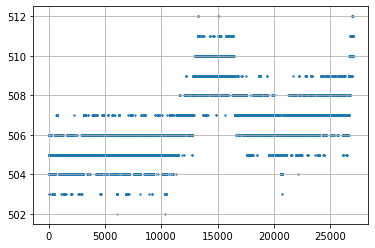

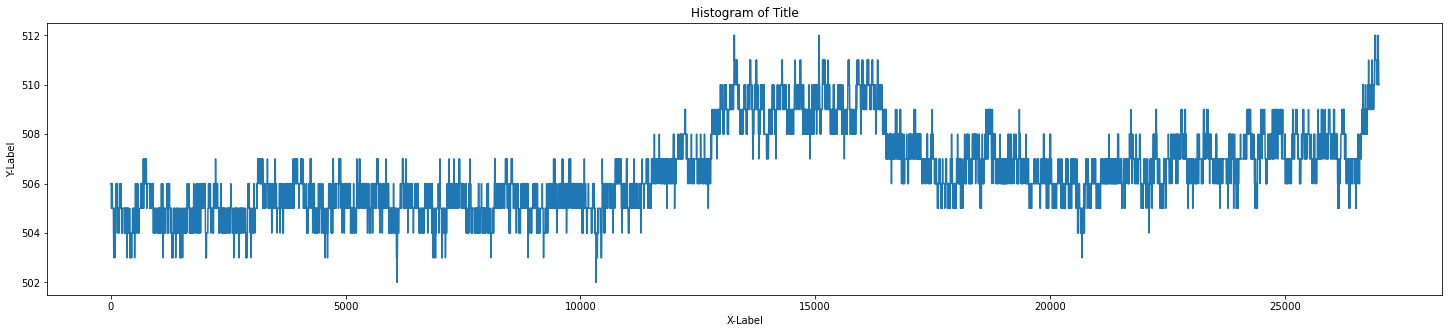

,EA89
2019-10-01 03:40:00,506
2019-10-01 03:40:01,506
2019-10-01 03:40:02,506
2019-10-01 03:40:03,506
2019-10-01 03:40:04,506
...,...
2019-10-01 11:09:55,510
2019-10-01 11:09:56,510
2019-10-01 11:09:57,510
2019-10-01 11:09:58,510


In [8]:
plot_x = np.arange(27000)
plot_y = x1

#plt.text(60, 58.1, r'$\mu=100,\ \sigma=15$')
#plt.axis([0, 180, 56.5, 58.5])
plt.grid(True)

#plt.legend(df.columns)
plt.scatter(plot_x,plot_y, s=1)
plt.figure(figsize=(25,5))
plt.xlabel('X-Label')
plt.ylabel('Y-Label')
plt.title('Histogram of Title')
plt.plot(plot_x,plot_y)
plt.show()
x1

In [9]:
#지수 이동평균 EMA (Exponetial Moving Average)
print(x1.shape)
x1 = x1.ewm(170).mean()
print(x1.shape)
x1

#print(df['EA90'].shape)
#df['EA90']
#df.columns

(27000, 1)
(27000, 1)


,EA89
2019-10-01 03:40:00,506.000000
2019-10-01 03:40:01,506.000000
2019-10-01 03:40:02,506.000000
2019-10-01 03:40:03,506.000000
2019-10-01 03:40:04,506.000000
...,...
2019-10-01 11:09:55,509.821987
2019-10-01 11:09:56,509.823028
2019-10-01 11:09:57,509.824063
2019-10-01 11:09:58,509.825091


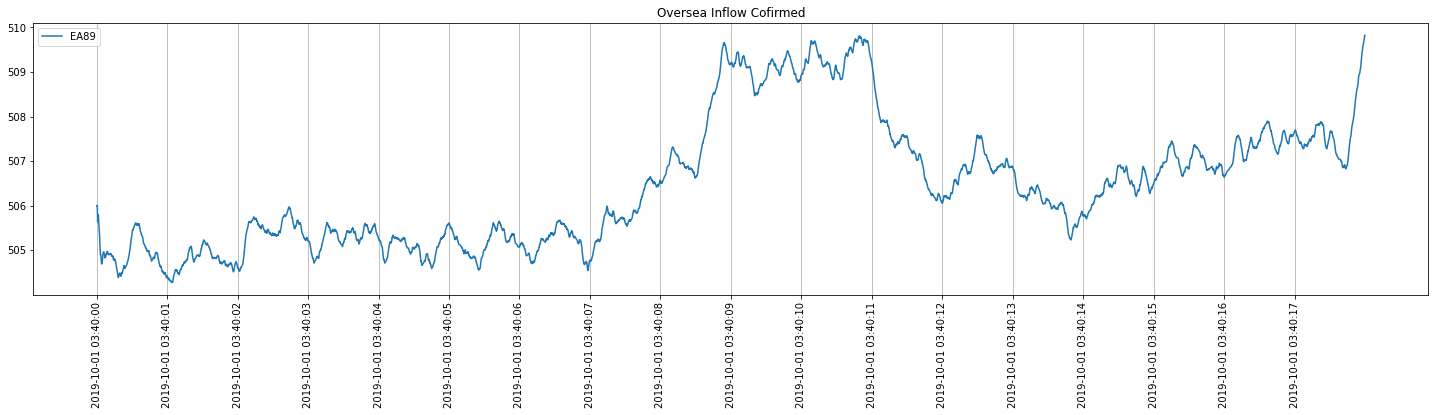

In [10]:
plt.figure(figsize=(25,5))
plt.plot(x1, label='EA89')
plt.xticks(np.arange(0,x1.shape[0],step=1500),x1.index, rotation=90)
#plt.axhline(y=506.3, xmin=0.02, xmax=0.98, color='red')
plt.title("Oversea Inflow Cofirmed")
plt.legend()
plt.grid(axis='x')

In [11]:
# 첫번째
# configure
n_lag = 3499 #모델링에 사용 된 지연 수
n_seq = 3600  #지속할 예측 단계의 수
n_test = 1
n_epochs = 30
n_batch = 100
n_neurons = 150

# prepare data
# 데이터를 변경하고 크기를 재조정한 다음, 지속성(persistence) 예제를 사용하여 감독된 학습 문제로 변환을 수행하고 테스트 세트를 훈련
scaler, train, test = prepare_data(x1, n_test, n_lag, n_seq)

# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 1, 150)             2190000   
_________________________________________________________________
lstm_1 (LSTM)                (100, 1, 90)              86760     
_________________________________________________________________
bidirectional (Bidirectional (100, 120)                72480     
_________________________________________________________________
dense (Dense)                (100, 3600)               435600    
Total params: 2,784,840
Trainable params: 2,784,840
Non-trainable params: 0
_________________________________________________________________
None
Total epoch: 1 / 30
Train on 19900 samples
19900/19900 [==============================] - 17s 871us/sample - loss: 0.0178
Total epoch: 2 / 30
Train on 19900 samples
19900/19900 [==============================] - 12s 604us/sample - loss: 0.

In [12]:

#다른 배치사이즈 적용
n_batch = 1

X1, y1 = train[:, 0:n_lag], train[:, n_lag:]
X1 = X1.reshape(X1.shape[0], 1, X1.shape[1])

new_model =  Sequential()
new_model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X1.shape[1], X1.shape[2])
                  ,return_sequences=True, stateful=True, dropout=0.2))
new_model.add(LSTM(90, return_sequences=True,stateful=True, dropout=0.2))
new_model.add(Bidirectional(LSTM(60, return_sequences = False)))
new_model.add(Dense(y1.shape[1]))

old_weights = model.get_weights()
new_model.set_weights(old_weights)

new_model.compile(loss='mse', optimizer='RMSprop')
print(new_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 1, 150)               2190000   
_________________________________________________________________
lstm_4 (LSTM)                (1, 1, 90)                86760     
_________________________________________________________________
bidirectional_1 (Bidirection (1, 120)                  72480     
_________________________________________________________________
dense_1 (Dense)              (1, 3600)                 435600    
Total params: 2,784,840
Trainable params: 2,784,840
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
from keras.models import load_model

new_model.save('model1.h5')

3600
t+1 RMSE: 0.003007
t+2 RMSE: 0.005788
t+3 RMSE: 0.002215
t+4 RMSE: 0.001087
t+5 RMSE: 0.004555
t+6 RMSE: 0.001829
t+7 RMSE: 0.000954
t+8 RMSE: 0.003469
t+9 RMSE: 0.006099
t+10 RMSE: 0.008515
t+11 RMSE: 0.010929
t+12 RMSE: 0.013453
t+13 RMSE: 0.016018
t+14 RMSE: 0.018599
t+15 RMSE: 0.020987
t+16 RMSE: 0.023298
t+17 RMSE: 0.025692
t+18 RMSE: 0.028042
t+19 RMSE: 0.031007
t+20 RMSE: 0.033390
t+21 RMSE: 0.036009
t+22 RMSE: 0.038378
t+23 RMSE: 0.040892
t+24 RMSE: 0.043614
t+25 RMSE: 0.045893
t+26 RMSE: 0.048331
t+27 RMSE: 0.050792
t+28 RMSE: 0.047172
t+29 RMSE: 0.043731
t+30 RMSE: 0.046022
t+31 RMSE: 0.048462
t+32 RMSE: 0.050480
t+33 RMSE: 0.053204
t+34 RMSE: 0.055596
t+35 RMSE: 0.058046
t+36 RMSE: 0.060509
t+37 RMSE: 0.062452
t+38 RMSE: 0.064775
t+39 RMSE: 0.067105
t+40 RMSE: 0.069639
t+41 RMSE: 0.071862
t+42 RMSE: 0.074115
t+43 RMSE: 0.076580
t+44 RMSE: 0.079013
t+45 RMSE: 0.081478
t+46 RMSE: 0.083880
t+47 RMSE: 0.086408
t+48 RMSE: 0.088850
t+49 RMSE: 0.091001
t+50 RMSE: 0.093632
t+51

t+907 RMSE: 0.419296
t+908 RMSE: 0.421478
t+909 RMSE: 0.423780
t+910 RMSE: 0.420176
t+911 RMSE: 0.416295
t+912 RMSE: 0.412528
t+913 RMSE: 0.409080
t+914 RMSE: 0.405397
t+915 RMSE: 0.401842
t+916 RMSE: 0.398578
t+917 RMSE: 0.395190
t+918 RMSE: 0.391717
t+919 RMSE: 0.388206
t+920 RMSE: 0.384748
t+921 RMSE: 0.381541
t+922 RMSE: 0.378219
t+923 RMSE: 0.374661
t+924 RMSE: 0.371172
t+925 RMSE: 0.367857
t+926 RMSE: 0.364749
t+927 RMSE: 0.361337
t+928 RMSE: 0.357993
t+929 RMSE: 0.354826
t+930 RMSE: 0.351624
t+931 RMSE: 0.348895
t+932 RMSE: 0.345365
t+933 RMSE: 0.342223
t+934 RMSE: 0.339046
t+935 RMSE: 0.335773
t+936 RMSE: 0.338604
t+937 RMSE: 0.341382
t+938 RMSE: 0.338472
t+939 RMSE: 0.335701
t+940 RMSE: 0.332740
t+941 RMSE: 0.329490
t+942 RMSE: 0.326177
t+943 RMSE: 0.323240
t+944 RMSE: 0.320330
t+945 RMSE: 0.317464
t+946 RMSE: 0.314359
t+947 RMSE: 0.311230
t+948 RMSE: 0.308289
t+949 RMSE: 0.299650
t+950 RMSE: 0.290850
t+951 RMSE: 0.282110
t+952 RMSE: 0.273680
t+953 RMSE: 0.265669
t+954 RMSE: 0

t+1683 RMSE: 0.109183
t+1684 RMSE: 0.101244
t+1685 RMSE: 0.094162
t+1686 RMSE: 0.086754
t+1687 RMSE: 0.079501
t+1688 RMSE: 0.072145
t+1689 RMSE: 0.064807
t+1690 RMSE: 0.057806
t+1691 RMSE: 0.056507
t+1692 RMSE: 0.055101
t+1693 RMSE: 0.053823
t+1694 RMSE: 0.052276
t+1695 RMSE: 0.050731
t+1696 RMSE: 0.049546
t+1697 RMSE: 0.048304
t+1698 RMSE: 0.047116
t+1699 RMSE: 0.045938
t+1700 RMSE: 0.044532
t+1701 RMSE: 0.043401
t+1702 RMSE: 0.042013
t+1703 RMSE: 0.040839
t+1704 RMSE: 0.039799
t+1705 RMSE: 0.038334
t+1706 RMSE: 0.037287
t+1707 RMSE: 0.036015
t+1708 RMSE: 0.034947
t+1709 RMSE: 0.033828
t+1710 RMSE: 0.032513
t+1711 RMSE: 0.031234
t+1712 RMSE: 0.030177
t+1713 RMSE: 0.023326
t+1714 RMSE: 0.016448
t+1715 RMSE: 0.015512
t+1716 RMSE: 0.014649
t+1717 RMSE: 0.007801
t+1718 RMSE: 0.001349
t+1719 RMSE: 0.000663
t+1720 RMSE: 0.000385
t+1721 RMSE: 0.001323
t+1722 RMSE: 0.002089
t+1723 RMSE: 0.002802
t+1724 RMSE: 0.004050
t+1725 RMSE: 0.004840
t+1726 RMSE: 0.005947
t+1727 RMSE: 0.007101
t+1728 RMS

t+2464 RMSE: 0.506285
t+2465 RMSE: 0.509401
t+2466 RMSE: 0.512844
t+2467 RMSE: 0.516098
t+2468 RMSE: 0.519175
t+2469 RMSE: 0.522476
t+2470 RMSE: 0.525246
t+2471 RMSE: 0.528100
t+2472 RMSE: 0.531050
t+2473 RMSE: 0.533996
t+2474 RMSE: 0.536895
t+2475 RMSE: 0.539776
t+2476 RMSE: 0.537062
t+2477 RMSE: 0.533927
t+2478 RMSE: 0.531456
t+2479 RMSE: 0.528631
t+2480 RMSE: 0.526165
t+2481 RMSE: 0.529151
t+2482 RMSE: 0.531883
t+2483 RMSE: 0.534975
t+2484 RMSE: 0.537919
t+2485 RMSE: 0.541058
t+2486 RMSE: 0.544124
t+2487 RMSE: 0.547345
t+2488 RMSE: 0.550728
t+2489 RMSE: 0.553709
t+2490 RMSE: 0.556759
t+2491 RMSE: 0.559758
t+2492 RMSE: 0.562760
t+2493 RMSE: 0.565456
t+2494 RMSE: 0.562574
t+2495 RMSE: 0.559343
t+2496 RMSE: 0.556441
t+2497 RMSE: 0.553669
t+2498 RMSE: 0.556812
t+2499 RMSE: 0.559690
t+2500 RMSE: 0.562896
t+2501 RMSE: 0.565842
t+2502 RMSE: 0.568716
t+2503 RMSE: 0.571315
t+2504 RMSE: 0.574268
t+2505 RMSE: 0.577185
t+2506 RMSE: 0.580029
t+2507 RMSE: 0.577304
t+2508 RMSE: 0.574114
t+2509 RMS

t+3315 RMSE: 1.046800
t+3316 RMSE: 1.060972
t+3317 RMSE: 1.074639
t+3318 RMSE: 1.088567
t+3319 RMSE: 1.096368
t+3320 RMSE: 1.104123
t+3321 RMSE: 1.111873
t+3322 RMSE: 1.119854
t+3323 RMSE: 1.127675
t+3324 RMSE: 1.135576
t+3325 RMSE: 1.142962
t+3326 RMSE: 1.150745
t+3327 RMSE: 1.158015
t+3328 RMSE: 1.159942
t+3329 RMSE: 1.161537
t+3330 RMSE: 1.168805
t+3331 RMSE: 1.176466
t+3332 RMSE: 1.183515
t+3333 RMSE: 1.190759
t+3334 RMSE: 1.191991
t+3335 RMSE: 1.193609
t+3336 RMSE: 1.200700
t+3337 RMSE: 1.208072
t+3338 RMSE: 1.215153
t+3339 RMSE: 1.221859
t+3340 RMSE: 1.228945
t+3341 RMSE: 1.235675
t+3342 RMSE: 1.242069
t+3343 RMSE: 1.248712
t+3344 RMSE: 1.255413
t+3345 RMSE: 1.262168
t+3346 RMSE: 1.269016
t+3347 RMSE: 1.269655
t+3348 RMSE: 1.270443
t+3349 RMSE: 1.270771
t+3350 RMSE: 1.277693
t+3351 RMSE: 1.284426
t+3352 RMSE: 1.291313
t+3353 RMSE: 1.297945
t+3354 RMSE: 1.304315
t+3355 RMSE: 1.310863
t+3356 RMSE: 1.317306
t+3357 RMSE: 1.323457
t+3358 RMSE: 1.329944
t+3359 RMSE: 1.336257
t+3360 RMS

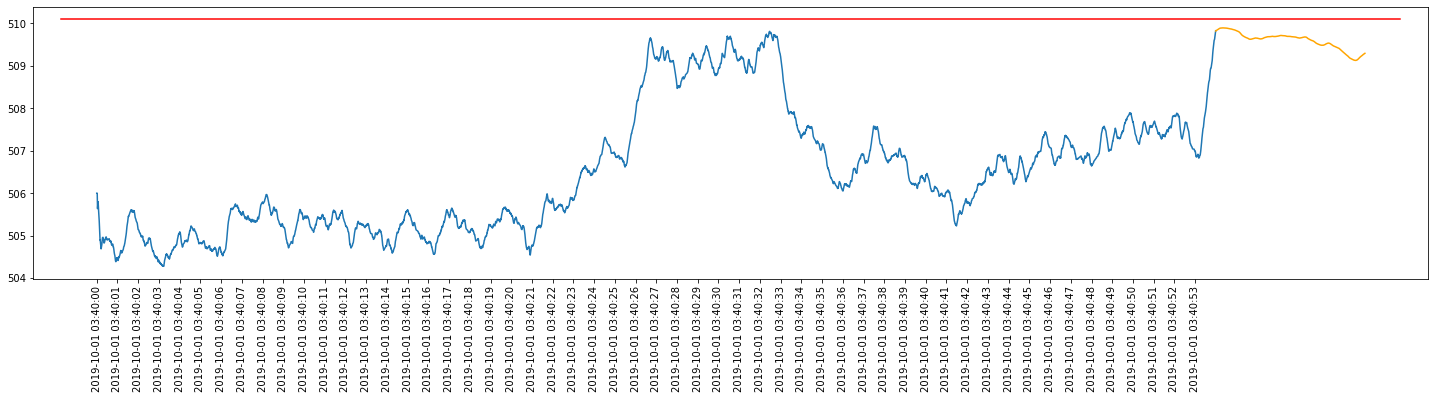

In [14]:

# make forecasts
forecasts = make_forecasts(new_model, n_batch, train, test, n_lag, n_seq)

# inverse transform forecasts and test
forecasts = inverse_transform(x1, forecasts, scaler, n_test+2)
#print(forecasts)
print(len(forecasts[0]))
actual = [row[n_lag:] for row in test]
actual = inverse_transform(x1, actual, scaler, n_test+2)

# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

# plot forecasts
plot_forecasts(x1, forecasts, n_test+2, 510.1)
#x1

In [15]:
print(len(forecasts[0]))
for i in range(len(forecasts[0])):
    #print(i,": ",forecasts[0][i])
    if(forecasts[0][i] > 510.1):
        alert = alert +1
        break
        
print(alert)

3600
0


In [16]:
print(forecasts)

[[array([509.82414477]), array([509.82504797]), array([509.82545498]), array([509.82611061]), array([509.8265765]), array([509.82736516]), array([509.82822312]), array([509.8288233]), array([509.82955091]), array([509.83007405]), array([509.83060778]), array([509.83126109]), array([509.83196715]), array([509.83269992]), array([509.83325102]), array([509.83373528]), array([509.83431354]), array([509.83485862]), array([509.83602884]), array([509.83662772]), array([509.83747244]), array([509.83807841]), array([509.83883887]), array([509.83981827]), array([509.84036419]), array([509.84107982]), array([509.84182856]), array([509.84235417]), array([509.84303455]), array([509.84357409]), array([509.84427362]), array([509.8445621]), array([509.84556565]), array([509.846247]), array([509.84699747]), array([509.84776982]), array([509.8480327]), array([509.84868437]), array([509.84935387]), array([509.85023669]), array([509.85081813]), array([509.8514394]), array([509.85228287]), array([509.85310

In [17]:
#2번째

In [18]:
del(scaler)
del(train)
del(test)
del(model)
del(new_model)
del(forecasts)
del(actual)
del(old_weights)
del(X1)
del(x1)

In [8]:
#지수 이동평균 EMA (Exponetial Moving Average)
x2 = x2.ewm(170).mean()
#print(x2.shape)
#x2

#print(df['EA90'].shape)
#df['EA90']
#df.columns

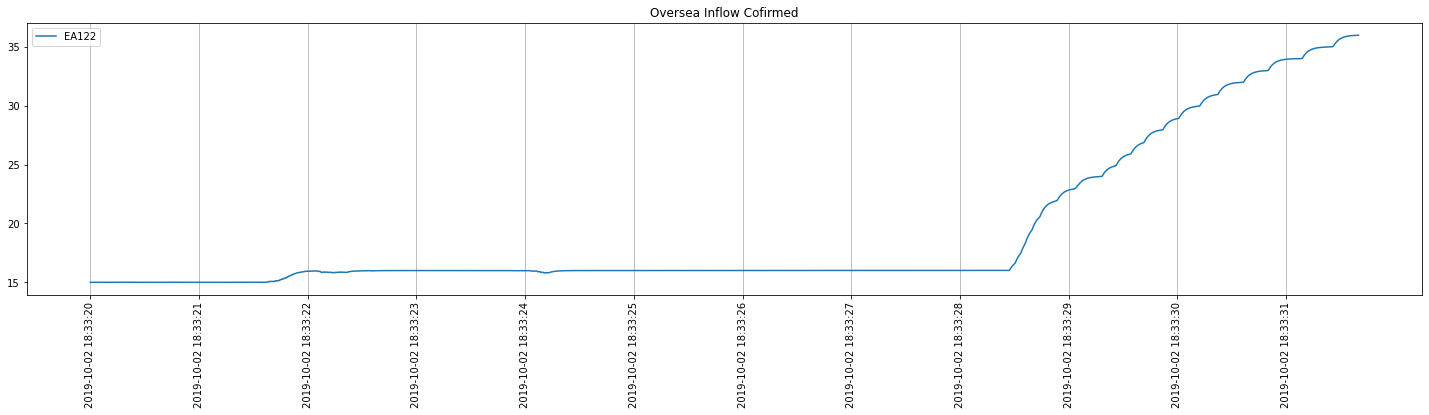

In [9]:
plt.figure(figsize=(25,5))
plt.plot(x2, label='EA122')
plt.xticks(np.arange(0,x2.shape[0],step=3000),x2.index, rotation=90)
#plt.axhline(y=506.3, xmin=0.02, xmax=0.98, color='red')
plt.title("Oversea Inflow Cofirmed")
plt.legend()
plt.grid(axis='x')

In [10]:

# configure
n_lag = 1599 #모델링에 사용 된 지연 수
n_seq = 4600  #지속할 예측 단계의 수
n_test = 1
n_epochs = 30
n_batch = 200
n_neurons = 150

# prepare data
# 데이터를 변경하고 크기를 재조정한 다음, 지속성(persistence) 예제를 사용하여 감독된 학습 문제로 변환을 수행하고 테스트 세트를 훈련
scaler, train, test = prepare_data(x2, n_test, n_lag, n_seq)

# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (200, 1, 150)             1050000   
_________________________________________________________________
lstm_1 (LSTM)                (200, 1, 90)              86760     
_________________________________________________________________
bidirectional (Bidirectional (200, 120)                72480     
_________________________________________________________________
dense (Dense)                (200, 4600)               556600    
Total params: 1,765,840
Trainable params: 1,765,840
Non-trainable params: 0
_________________________________________________________________
None
Total epoch: 1 / 30
Train on 28800 samples
28800/28800 [==============================] - 13s 441us/sample - loss: 0.0256
Total epoch: 2 / 30
Train on 28800 samples
28800/28800 [==============================] - 9s 318us/sample - loss: 0.0

In [11]:

#다른 배치사이즈 적용
n_batch = 1

X2, y2 = train[:, 0:n_lag], train[:, n_lag:]
X2 = X2.reshape(X2.shape[0], 1, X2.shape[1])

new_model =  Sequential()
new_model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X2.shape[1], X2.shape[2])
                  ,return_sequences=True, stateful=True, dropout=0.2))
new_model.add(LSTM(90, return_sequences=True,stateful=True, dropout=0.2))
new_model.add(Bidirectional(LSTM(60, return_sequences = False)))
new_model.add(Dense(y2.shape[1]))

old_weights = model.get_weights()
new_model.set_weights(old_weights)

new_model.compile(loss='mse', optimizer='RMSprop')
print(new_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 1, 150)               1050000   
_________________________________________________________________
lstm_4 (LSTM)                (1, 1, 90)                86760     
_________________________________________________________________
bidirectional_1 (Bidirection (1, 120)                  72480     
_________________________________________________________________
dense_1 (Dense)              (1, 4600)                 556600    
Total params: 1,765,840
Trainable params: 1,765,840
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
from keras.models import load_model

new_model.save('model2.h5')

t+1 RMSE: 0.000865
t+2 RMSE: 0.001741
t+3 RMSE: 0.002622
t+4 RMSE: 0.003462
t+5 RMSE: 0.004281
t+6 RMSE: 0.005175
t+7 RMSE: 0.006036
t+8 RMSE: 0.006894
t+9 RMSE: 0.007683
t+10 RMSE: 0.008479
t+11 RMSE: 0.009293
t+12 RMSE: 0.010136
t+13 RMSE: 0.010942
t+14 RMSE: 0.011769
t+15 RMSE: 0.012697
t+16 RMSE: 0.013518
t+17 RMSE: 0.014347
t+18 RMSE: 0.015164
t+19 RMSE: 0.016007
t+20 RMSE: 0.016843
t+21 RMSE: 0.017689
t+22 RMSE: 0.018531
t+23 RMSE: 0.019367
t+24 RMSE: 0.020173
t+25 RMSE: 0.021026
t+26 RMSE: 0.021824
t+27 RMSE: 0.022661
t+28 RMSE: 0.023430
t+29 RMSE: 0.024236
t+30 RMSE: 0.025007
t+31 RMSE: 0.025860
t+32 RMSE: 0.026726
t+33 RMSE: 0.027507
t+34 RMSE: 0.028351
t+35 RMSE: 0.029105
t+36 RMSE: 0.029897
t+37 RMSE: 0.030705
t+38 RMSE: 0.031456
t+39 RMSE: 0.032222
t+40 RMSE: 0.033043
t+41 RMSE: 0.033818
t+42 RMSE: 0.034508
t+43 RMSE: 0.035357
t+44 RMSE: 0.036099
t+45 RMSE: 0.036869
t+46 RMSE: 0.037587
t+47 RMSE: 0.038396
t+48 RMSE: 0.039139
t+49 RMSE: 0.039933
t+50 RMSE: 0.040716
t+51 RMSE

t+1011 RMSE: 0.392104
t+1012 RMSE: 0.392323
t+1013 RMSE: 0.392514
t+1014 RMSE: 0.392627
t+1015 RMSE: 0.392877
t+1016 RMSE: 0.393026
t+1017 RMSE: 0.393227
t+1018 RMSE: 0.393409
t+1019 RMSE: 0.393651
t+1020 RMSE: 0.393998
t+1021 RMSE: 0.394283
t+1022 RMSE: 0.394549
t+1023 RMSE: 0.394819
t+1024 RMSE: 0.395038
t+1025 RMSE: 0.395228
t+1026 RMSE: 0.395361
t+1027 RMSE: 0.395560
t+1028 RMSE: 0.395823
t+1029 RMSE: 0.395998
t+1030 RMSE: 0.396266
t+1031 RMSE: 0.396446
t+1032 RMSE: 0.396604
t+1033 RMSE: 0.396822
t+1034 RMSE: 0.397044
t+1035 RMSE: 0.397227
t+1036 RMSE: 0.397365
t+1037 RMSE: 0.397460
t+1038 RMSE: 0.397623
t+1039 RMSE: 0.397841
t+1040 RMSE: 0.398106
t+1041 RMSE: 0.398322
t+1042 RMSE: 0.398573
t+1043 RMSE: 0.398808
t+1044 RMSE: 0.399043
t+1045 RMSE: 0.399203
t+1046 RMSE: 0.399395
t+1047 RMSE: 0.399556
t+1048 RMSE: 0.399769
t+1049 RMSE: 0.399934
t+1050 RMSE: 0.400120
t+1051 RMSE: 0.400290
t+1052 RMSE: 0.400454
t+1053 RMSE: 0.400602
t+1054 RMSE: 0.400675
t+1055 RMSE: 0.400869
t+1056 RMS

t+1784 RMSE: 0.518021
t+1785 RMSE: 0.518028
t+1786 RMSE: 0.518021
t+1787 RMSE: 0.518046
t+1788 RMSE: 0.518074
t+1789 RMSE: 0.518036
t+1790 RMSE: 0.518112
t+1791 RMSE: 0.518116
t+1792 RMSE: 0.518098
t+1793 RMSE: 0.518060
t+1794 RMSE: 0.518050
t+1795 RMSE: 0.517981
t+1796 RMSE: 0.517912
t+1797 RMSE: 0.517864
t+1798 RMSE: 0.517818
t+1799 RMSE: 0.517758
t+1800 RMSE: 0.517719
t+1801 RMSE: 0.517733
t+1802 RMSE: 0.517703
t+1803 RMSE: 0.517708
t+1804 RMSE: 0.517542
t+1805 RMSE: 0.517430
t+1806 RMSE: 0.517410
t+1807 RMSE: 0.517376
t+1808 RMSE: 0.517255
t+1809 RMSE: 0.517141
t+1810 RMSE: 0.516986
t+1811 RMSE: 0.516935
t+1812 RMSE: 0.516853
t+1813 RMSE: 0.516734
t+1814 RMSE: 0.516562
t+1815 RMSE: 0.516446
t+1816 RMSE: 0.516271
t+1817 RMSE: 0.516127
t+1818 RMSE: 0.516007
t+1819 RMSE: 0.515889
t+1820 RMSE: 0.515738
t+1821 RMSE: 0.515588
t+1822 RMSE: 0.515403
t+1823 RMSE: 0.515245
t+1824 RMSE: 0.515093
t+1825 RMSE: 0.514866
t+1826 RMSE: 0.514806
t+1827 RMSE: 0.514611
t+1828 RMSE: 0.514374
t+1829 RMS

t+2609 RMSE: 0.475448
t+2610 RMSE: 0.474228
t+2611 RMSE: 0.473000
t+2612 RMSE: 0.471789
t+2613 RMSE: 0.470536
t+2614 RMSE: 0.469367
t+2615 RMSE: 0.468225
t+2616 RMSE: 0.467035
t+2617 RMSE: 0.465877
t+2618 RMSE: 0.464685
t+2619 RMSE: 0.463386
t+2620 RMSE: 0.462096
t+2621 RMSE: 0.460845
t+2622 RMSE: 0.459664
t+2623 RMSE: 0.458426
t+2624 RMSE: 0.457194
t+2625 RMSE: 0.455859
t+2626 RMSE: 0.454656
t+2627 RMSE: 0.453548
t+2628 RMSE: 0.452305
t+2629 RMSE: 0.451119
t+2630 RMSE: 0.449976
t+2631 RMSE: 0.448762
t+2632 RMSE: 0.447499
t+2633 RMSE: 0.446314
t+2634 RMSE: 0.445081
t+2635 RMSE: 0.443864
t+2636 RMSE: 0.442653
t+2637 RMSE: 0.441420
t+2638 RMSE: 0.440173
t+2639 RMSE: 0.439003
t+2640 RMSE: 0.437874
t+2641 RMSE: 0.436729
t+2642 RMSE: 0.435513
t+2643 RMSE: 0.434310
t+2644 RMSE: 0.433162
t+2645 RMSE: 0.431947
t+2646 RMSE: 0.430841
t+2647 RMSE: 0.429680
t+2648 RMSE: 0.428496
t+2649 RMSE: 0.427442
t+2650 RMSE: 0.426272
t+2651 RMSE: 0.425192
t+2652 RMSE: 0.424011
t+2653 RMSE: 0.422808
t+2654 RMS

t+3485 RMSE: 0.366461
t+3486 RMSE: 0.366638
t+3487 RMSE: 0.366809
t+3488 RMSE: 0.366976
t+3489 RMSE: 0.367088
t+3490 RMSE: 0.367245
t+3491 RMSE: 0.367355
t+3492 RMSE: 0.367390
t+3493 RMSE: 0.367571
t+3494 RMSE: 0.367778
t+3495 RMSE: 0.367883
t+3496 RMSE: 0.367994
t+3497 RMSE: 0.368082
t+3498 RMSE: 0.368192
t+3499 RMSE: 0.368323
t+3500 RMSE: 0.368467
t+3501 RMSE: 0.368493
t+3502 RMSE: 0.368569
t+3503 RMSE: 0.368570
t+3504 RMSE: 0.368650
t+3505 RMSE: 0.368677
t+3506 RMSE: 0.368772
t+3507 RMSE: 0.368790
t+3508 RMSE: 0.368851
t+3509 RMSE: 0.368856
t+3510 RMSE: 0.368856
t+3511 RMSE: 0.368808
t+3512 RMSE: 0.368916
t+3513 RMSE: 0.368928
t+3514 RMSE: 0.368858
t+3515 RMSE: 0.368739
t+3516 RMSE: 0.368618
t+3517 RMSE: 0.368663
t+3518 RMSE: 0.368626
t+3519 RMSE: 0.368663
t+3520 RMSE: 0.368665
t+3521 RMSE: 0.368662
t+3522 RMSE: 0.368701
t+3523 RMSE: 0.368760
t+3524 RMSE: 0.368706
t+3525 RMSE: 0.368597
t+3526 RMSE: 0.368521
t+3527 RMSE: 0.368428
t+3528 RMSE: 0.368348
t+3529 RMSE: 0.368287
t+3530 RMS

t+4347 RMSE: 0.411836
t+4348 RMSE: 0.411114
t+4349 RMSE: 0.410330
t+4350 RMSE: 0.409584
t+4351 RMSE: 0.408873
t+4352 RMSE: 0.408139
t+4353 RMSE: 0.407337
t+4354 RMSE: 0.406650
t+4355 RMSE: 0.405892
t+4356 RMSE: 0.405187
t+4357 RMSE: 0.404488
t+4358 RMSE: 0.403700
t+4359 RMSE: 0.402968
t+4360 RMSE: 0.402166
t+4361 RMSE: 0.401367
t+4362 RMSE: 0.400640
t+4363 RMSE: 0.399845
t+4364 RMSE: 0.399136
t+4365 RMSE: 0.398343
t+4366 RMSE: 0.397567
t+4367 RMSE: 0.396635
t+4368 RMSE: 0.395733
t+4369 RMSE: 0.394790
t+4370 RMSE: 0.393875
t+4371 RMSE: 0.392911
t+4372 RMSE: 0.392007
t+4373 RMSE: 0.391050
t+4374 RMSE: 0.390128
t+4375 RMSE: 0.389225
t+4376 RMSE: 0.388227
t+4377 RMSE: 0.387204
t+4378 RMSE: 0.386172
t+4379 RMSE: 0.385209
t+4380 RMSE: 0.384258
t+4381 RMSE: 0.383318
t+4382 RMSE: 0.382352
t+4383 RMSE: 0.381465
t+4384 RMSE: 0.380472
t+4385 RMSE: 0.379537
t+4386 RMSE: 0.378547
t+4387 RMSE: 0.377556
t+4388 RMSE: 0.376547
t+4389 RMSE: 0.375558
t+4390 RMSE: 0.374526
t+4391 RMSE: 0.373501
t+4392 RMS

,EA122
2019-10-02 18:33:20,15.000000
2019-10-02 18:33:21,15.000000
2019-10-02 18:33:22,15.000000
2019-10-02 18:33:23,15.000000
2019-10-02 18:33:24,15.000000
...,...
2019-10-03 04:46:35,35.983330
2019-10-03 04:46:36,35.983427
2019-10-03 04:46:37,35.983524
2019-10-03 04:46:38,35.983620


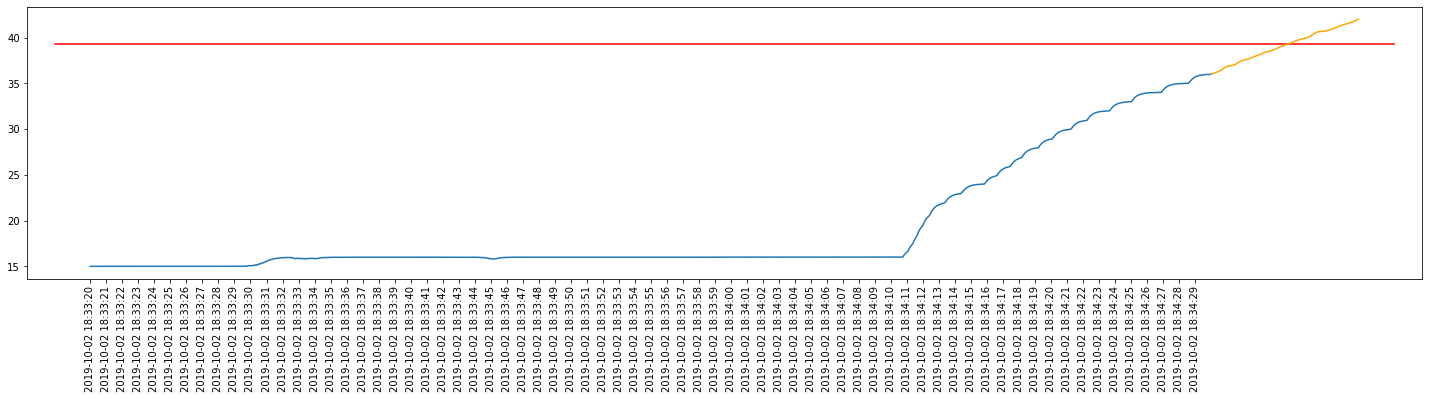

In [13]:

# make forecasts
forecasts = make_forecasts(new_model, n_batch, train, test, n_lag, n_seq)

# inverse transform forecasts and test
forecasts = inverse_transform(x2, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(x2, actual, scaler, n_test+2)

# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

# plot forecasts
plot_forecasts(x2, forecasts, n_test+2, 39.3)
x2

In [14]:
for i in range(len(forecasts[0])):
    #print(i,": ",forecasts[0][i])
    if(forecasts[0][i] > 39.3):
        alert = alert +1
        break
        
print(alert)

1


In [15]:
del(scaler)
del(train)
del(test)
del(model)
del(new_model)
del(forecasts)
del(actual)
del(old_weights)
del(X2)
del(x2)

In [16]:
#3번째

In [17]:
#지수 이동평균 EMA (Exponetial Moving Average)
x3 = x3.ewm(170).mean()
#print(x3.shape)
#x3

#print(df['EA90'].shape)
#df['EA90']
#df.columns

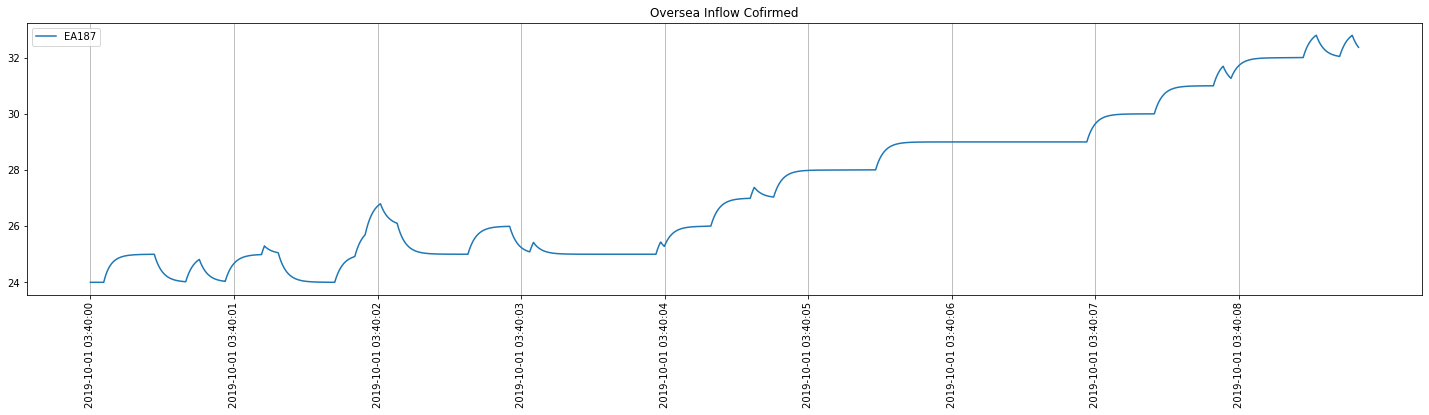

In [18]:
plt.figure(figsize=(25,5))
plt.plot(x3, label='EA187')
plt.xticks(np.arange(0, x3.shape[0], step=3000), x3.index, rotation=90)
#plt.axhline(y=506.3, xmin=0.02, xmax=0.98, color='red')
plt.title("Oversea Inflow Cofirmed")
plt.legend()
plt.grid(axis='x')

In [19]:

# configure
n_lag = 1499 #모델링에 사용 된 지연 수
n_seq = 4600  #지속할 예측 단계의 수
n_test = 1
n_epochs = 30
n_batch = 200
n_neurons = 150

# prepare data
# 데이터를 변경하고 크기를 재조정한 다음, 지속성(persistence) 예제를 사용하여 감독된 학습 문제로 변환을 수행하고 테스트 세트를 훈련
scaler, train, test = prepare_data(x3, n_test, n_lag, n_seq)

# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (200, 1, 150)             990000    
_________________________________________________________________
lstm_7 (LSTM)                (200, 1, 90)              86760     
_________________________________________________________________
bidirectional_2 (Bidirection (200, 120)                72480     
_________________________________________________________________
dense_2 (Dense)              (200, 4600)               556600    
Total params: 1,705,840
Trainable params: 1,705,840
Non-trainable params: 0
_________________________________________________________________
None
Total epoch: 1 / 30
Train on 20400 samples
20400/20400 [==============================] - 11s 552us/sample - loss: 0.0489
Total epoch: 2 / 30
Train on 20400 samples
20400/20400 [==============================] - 5s 265us/sample - loss: 0

In [20]:

#다른 배치사이즈 적용
n_batch = 1

X3, y3 = train[:, 0:n_lag], train[:, n_lag:]
X3 = X3.reshape(X3.shape[0], 1, X3.shape[1])

new_model =  Sequential()
new_model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X3.shape[1], X3.shape[2])
                  ,return_sequences=True, stateful=True, dropout=0.2))
new_model.add(LSTM(90, return_sequences=True,stateful=True, dropout=0.2))
new_model.add(Bidirectional(LSTM(60, return_sequences = False)))
new_model.add(Dense(y3.shape[1]))

old_weights = model.get_weights()
new_model.set_weights(old_weights)

new_model.compile(loss='mse', optimizer='RMSprop')
print(new_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (1, 1, 150)               990000    
_________________________________________________________________
lstm_10 (LSTM)               (1, 1, 90)                86760     
_________________________________________________________________
bidirectional_3 (Bidirection (1, 120)                  72480     
_________________________________________________________________
dense_3 (Dense)              (1, 4600)                 556600    
Total params: 1,705,840
Trainable params: 1,705,840
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
from keras.models import load_model

new_model.save('model3.h5')

t+1 RMSE: 0.000181
t+2 RMSE: 0.000380
t+3 RMSE: 0.000581
t+4 RMSE: 0.000771
t+5 RMSE: 0.001028
t+6 RMSE: 0.001238
t+7 RMSE: 0.001413
t+8 RMSE: 0.001669
t+9 RMSE: 0.001928
t+10 RMSE: 0.002168
t+11 RMSE: 0.002371
t+12 RMSE: 0.002622
t+13 RMSE: 0.002829
t+14 RMSE: 0.003052
t+15 RMSE: 0.003272
t+16 RMSE: 0.003511
t+17 RMSE: 0.003771
t+18 RMSE: 0.003992
t+19 RMSE: 0.004206
t+20 RMSE: 0.004398
t+21 RMSE: 0.004615
t+22 RMSE: 0.004874
t+23 RMSE: 0.005071
t+24 RMSE: 0.005275
t+25 RMSE: 0.005508
t+26 RMSE: 0.005745
t+27 RMSE: 0.005969
t+28 RMSE: 0.006174
t+29 RMSE: 0.006425
t+30 RMSE: 0.006712
t+31 RMSE: 0.006917
t+32 RMSE: 0.007169
t+33 RMSE: 0.007412
t+34 RMSE: 0.007692
t+35 RMSE: 0.007904
t+36 RMSE: 0.008166
t+37 RMSE: 0.008432
t+38 RMSE: 0.008608
t+39 RMSE: 0.008872
t+40 RMSE: 0.009112
t+41 RMSE: 0.009312
t+42 RMSE: 0.009587
t+43 RMSE: 0.009850
t+44 RMSE: 0.010032
t+45 RMSE: 0.010266
t+46 RMSE: 0.010541
t+47 RMSE: 0.010753
t+48 RMSE: 0.011011
t+49 RMSE: 0.011213
t+50 RMSE: 0.011415
t+51 RMSE

t+960 RMSE: 0.665531
t+961 RMSE: 0.665392
t+962 RMSE: 0.665261
t+963 RMSE: 0.665140
t+964 RMSE: 0.665017
t+965 RMSE: 0.664905
t+966 RMSE: 0.664755
t+967 RMSE: 0.664579
t+968 RMSE: 0.664441
t+969 RMSE: 0.664265
t+970 RMSE: 0.664072
t+971 RMSE: 0.663865
t+972 RMSE: 0.663669
t+973 RMSE: 0.663503
t+974 RMSE: 0.663305
t+975 RMSE: 0.663136
t+976 RMSE: 0.662925
t+977 RMSE: 0.662695
t+978 RMSE: 0.662504
t+979 RMSE: 0.662306
t+980 RMSE: 0.662041
t+981 RMSE: 0.661781
t+982 RMSE: 0.661548
t+983 RMSE: 0.661323
t+984 RMSE: 0.661116
t+985 RMSE: 0.660892
t+986 RMSE: 0.660615
t+987 RMSE: 0.660336
t+988 RMSE: 0.660065
t+989 RMSE: 0.659839
t+990 RMSE: 0.659545
t+991 RMSE: 0.659297
t+992 RMSE: 0.658984
t+993 RMSE: 0.658713
t+994 RMSE: 0.658400
t+995 RMSE: 0.658145
t+996 RMSE: 0.657784
t+997 RMSE: 0.657522
t+998 RMSE: 0.657237
t+999 RMSE: 0.656904
t+1000 RMSE: 0.656607
t+1001 RMSE: 0.656341
t+1002 RMSE: 0.656042
t+1003 RMSE: 0.655714
t+1004 RMSE: 0.655343
t+1005 RMSE: 0.655011
t+1006 RMSE: 0.654705
t+1007

t+1677 RMSE: 0.793747
t+1678 RMSE: 0.796085
t+1679 RMSE: 0.798417
t+1680 RMSE: 0.800725
t+1681 RMSE: 0.802983
t+1682 RMSE: 0.805255
t+1683 RMSE: 0.807484
t+1684 RMSE: 0.809707
t+1685 RMSE: 0.811949
t+1686 RMSE: 0.814141
t+1687 RMSE: 0.816369
t+1688 RMSE: 0.818514
t+1689 RMSE: 0.820712
t+1690 RMSE: 0.822841
t+1691 RMSE: 0.824965
t+1692 RMSE: 0.827125
t+1693 RMSE: 0.829230
t+1694 RMSE: 0.831344
t+1695 RMSE: 0.833425
t+1696 RMSE: 0.835437
t+1697 RMSE: 0.837490
t+1698 RMSE: 0.839483
t+1699 RMSE: 0.841456
t+1700 RMSE: 0.843464
t+1701 RMSE: 0.845416
t+1702 RMSE: 0.847406
t+1703 RMSE: 0.849354
t+1704 RMSE: 0.851260
t+1705 RMSE: 0.853136
t+1706 RMSE: 0.855015
t+1707 RMSE: 0.856860
t+1708 RMSE: 0.858755
t+1709 RMSE: 0.860608
t+1710 RMSE: 0.862424
t+1711 RMSE: 0.864245
t+1712 RMSE: 0.866077
t+1713 RMSE: 0.867839
t+1714 RMSE: 0.869595
t+1715 RMSE: 0.871365
t+1716 RMSE: 0.873071
t+1717 RMSE: 0.874845
t+1718 RMSE: 0.876589
t+1719 RMSE: 0.878312
t+1720 RMSE: 0.880010
t+1721 RMSE: 0.881704
t+1722 RMS

t+2524 RMSE: 0.959622
t+2525 RMSE: 0.959910
t+2526 RMSE: 0.960173
t+2527 RMSE: 0.960388
t+2528 RMSE: 0.960603
t+2529 RMSE: 0.960830
t+2530 RMSE: 0.961059
t+2531 RMSE: 0.961260
t+2532 RMSE: 0.961449
t+2533 RMSE: 0.961643
t+2534 RMSE: 0.961871
t+2535 RMSE: 0.962122
t+2536 RMSE: 0.962338
t+2537 RMSE: 0.962580
t+2538 RMSE: 0.962835
t+2539 RMSE: 0.963023
t+2540 RMSE: 0.963233
t+2541 RMSE: 0.963416
t+2542 RMSE: 0.963603
t+2543 RMSE: 0.963769
t+2544 RMSE: 0.963959
t+2545 RMSE: 0.964140
t+2546 RMSE: 0.964314
t+2547 RMSE: 0.964484
t+2548 RMSE: 0.964612
t+2549 RMSE: 0.964753
t+2550 RMSE: 0.964953
t+2551 RMSE: 0.965141
t+2552 RMSE: 0.965311
t+2553 RMSE: 0.965479
t+2554 RMSE: 0.965639
t+2555 RMSE: 0.965803
t+2556 RMSE: 0.965957
t+2557 RMSE: 0.966129
t+2558 RMSE: 0.966284
t+2559 RMSE: 0.966443
t+2560 RMSE: 0.966596
t+2561 RMSE: 0.966697
t+2562 RMSE: 0.966808
t+2563 RMSE: 0.966987
t+2564 RMSE: 0.967132
t+2565 RMSE: 0.967244
t+2566 RMSE: 0.967402
t+2567 RMSE: 0.967490
t+2568 RMSE: 0.967605
t+2569 RMS

t+3435 RMSE: 0.770707
t+3436 RMSE: 0.770267
t+3437 RMSE: 0.769834
t+3438 RMSE: 0.769418
t+3439 RMSE: 0.768991
t+3440 RMSE: 0.768556
t+3441 RMSE: 0.768131
t+3442 RMSE: 0.767759
t+3443 RMSE: 0.773171
t+3444 RMSE: 0.778569
t+3445 RMSE: 0.783893
t+3446 RMSE: 0.789164
t+3447 RMSE: 0.794413
t+3448 RMSE: 0.799638
t+3449 RMSE: 0.804818
t+3450 RMSE: 0.809958
t+3451 RMSE: 0.815137
t+3452 RMSE: 0.820202
t+3453 RMSE: 0.825305
t+3454 RMSE: 0.830342
t+3455 RMSE: 0.835329
t+3456 RMSE: 0.840291
t+3457 RMSE: 0.845257
t+3458 RMSE: 0.850136
t+3459 RMSE: 0.855015
t+3460 RMSE: 0.859847
t+3461 RMSE: 0.864668
t+3462 RMSE: 0.869493
t+3463 RMSE: 0.874267
t+3464 RMSE: 0.879005
t+3465 RMSE: 0.883668
t+3466 RMSE: 0.888331
t+3467 RMSE: 0.892951
t+3468 RMSE: 0.897523
t+3469 RMSE: 0.902058
t+3470 RMSE: 0.906546
t+3471 RMSE: 0.911035
t+3472 RMSE: 0.915545
t+3473 RMSE: 0.919984
t+3474 RMSE: 0.924390
t+3475 RMSE: 0.928800
t+3476 RMSE: 0.933169
t+3477 RMSE: 0.937506
t+3478 RMSE: 0.941823
t+3479 RMSE: 0.946125
t+3480 RMS

t+4266 RMSE: 0.704439
t+4267 RMSE: 0.707747
t+4268 RMSE: 0.710999
t+4269 RMSE: 0.714287
t+4270 RMSE: 0.717544
t+4271 RMSE: 0.720747
t+4272 RMSE: 0.723945
t+4273 RMSE: 0.727121
t+4274 RMSE: 0.730294
t+4275 RMSE: 0.733441
t+4276 RMSE: 0.736558
t+4277 RMSE: 0.739655
t+4278 RMSE: 0.742732
t+4279 RMSE: 0.745811
t+4280 RMSE: 0.748863
t+4281 RMSE: 0.751870
t+4282 RMSE: 0.754845
t+4283 RMSE: 0.757845
t+4284 RMSE: 0.760848
t+4285 RMSE: 0.763800
t+4286 RMSE: 0.766787
t+4287 RMSE: 0.769702
t+4288 RMSE: 0.772604
t+4289 RMSE: 0.775479
t+4290 RMSE: 0.778281
t+4291 RMSE: 0.781084
t+4292 RMSE: 0.783917
t+4293 RMSE: 0.786689
t+4294 RMSE: 0.789449
t+4295 RMSE: 0.792252
t+4296 RMSE: 0.795009
t+4297 RMSE: 0.797779
t+4298 RMSE: 0.800473
t+4299 RMSE: 0.803144
t+4300 RMSE: 0.805788
t+4301 RMSE: 0.808488
t+4302 RMSE: 0.811171
t+4303 RMSE: 0.813831
t+4304 RMSE: 0.816447
t+4305 RMSE: 0.819084
t+4306 RMSE: 0.821694
t+4307 RMSE: 0.824315
t+4308 RMSE: 0.826859
t+4309 RMSE: 0.829449
t+4310 RMSE: 0.831973
t+4311 RMS

,EA187
2019-10-01 03:40:00,24.000000
2019-10-01 03:40:01,24.000000
2019-10-01 03:40:02,24.000000
2019-10-01 03:40:03,24.000000
2019-10-01 03:40:04,24.000000
...,...
2019-10-01 11:01:35,32.377880
2019-10-01 11:01:36,32.375670
2019-10-01 11:01:37,32.373473
2019-10-01 11:01:38,32.371289


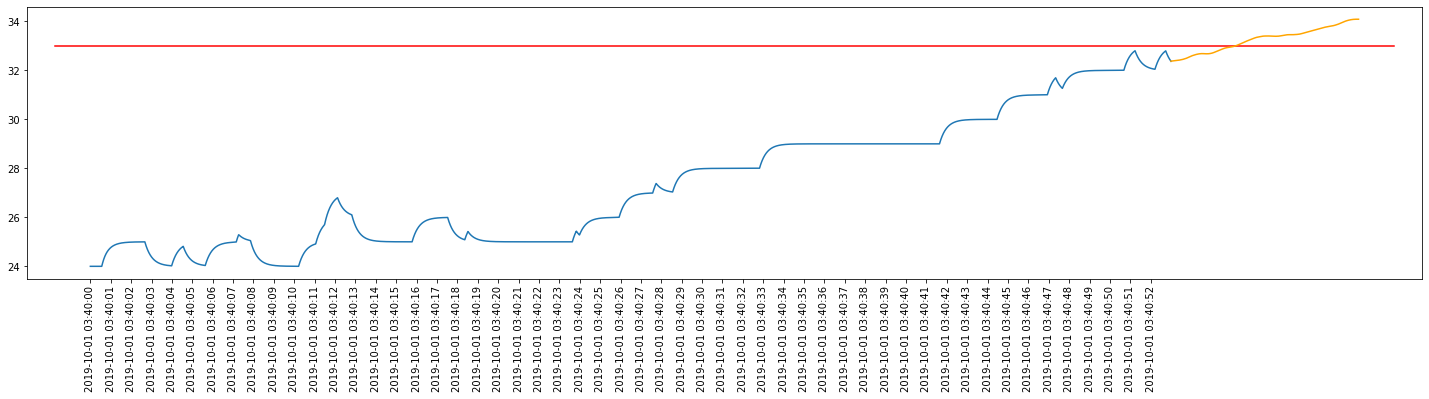

In [22]:

# make forecasts
forecasts = make_forecasts(new_model, n_batch, train, test, n_lag, n_seq)

# inverse transform forecasts and test
forecasts = inverse_transform(x3, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(x3, actual, scaler, n_test+2)

# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

# plot forecasts
plot_forecasts(x3, forecasts, n_test+2, 33)
x3

In [23]:
print(len(forecasts[0]))
for i in range(len(forecasts[0])):
    print(i,": ",forecasts[0][i])
    if(forecasts[0][i] > 33):
        alert = alert +1
        break
        
print(alert)

4600
0 :  [32.37586173]
1 :  [32.37607118]
2 :  [32.37628278]
3 :  [32.37648347]
4 :  [32.3767505]
5 :  [32.37697092]
6 :  [32.37715591]
7 :  [32.37742124]
8 :  [32.37769121]
9 :  [32.37794029]
10 :  [32.37815317]
11 :  [32.37841461]
12 :  [32.37863125]
13 :  [32.37886401]
14 :  [32.37909319]
15 :  [32.37934185]
16 :  [32.37961213]
17 :  [32.37984211]
18 :  [32.38006612]
19 :  [32.38026714]
20 :  [32.38049388]
21 :  [32.38076215]
22 :  [32.38096811]
23 :  [32.38118141]
24 :  [32.38142302]
25 :  [32.38166939]
26 :  [32.38190279]
27 :  [32.38211588]
28 :  [32.38237652]
29 :  [32.38267173]
30 :  [32.38288552]
31 :  [32.38314705]
32 :  [32.38339852]
33 :  [32.38368648]
34 :  [32.38390781]
35 :  [32.38417793]
36 :  [32.38445238]
37 :  [32.38463665]
38 :  [32.38490902]
39 :  [32.3851575]
40 :  [32.38536608]
41 :  [32.38564947]
42 :  [32.38592071]
43 :  [32.38611113]
44 :  [32.38635251]
45 :  [32.38663605]
46 :  [32.38685627]
47 :  [32.38712173]
48 :  [32.38733182]
49 :  [32.3875422]
50 :  [3

803 :  [32.6815266]
804 :  [32.6814423]
805 :  [32.68136596]
806 :  [32.68129742]
807 :  [32.68120005]
808 :  [32.68115854]
809 :  [32.68110526]
810 :  [32.68102694]
811 :  [32.68095567]
812 :  [32.68090598]
813 :  [32.6807766]
814 :  [32.68065643]
815 :  [32.68060635]
816 :  [32.68046975]
817 :  [32.68039018]
818 :  [32.6803136]
819 :  [32.68024538]
820 :  [32.68018274]
821 :  [32.68014357]
822 :  [32.68007667]
823 :  [32.67998339]
824 :  [32.67987402]
825 :  [32.67983073]
826 :  [32.67972633]
827 :  [32.67965672]
828 :  [32.67956689]
829 :  [32.67946615]
830 :  [32.67938137]
831 :  [32.67928467]
832 :  [32.67922546]
833 :  [32.67915722]
834 :  [32.67905766]
835 :  [32.6789773]
836 :  [32.67888079]
837 :  [32.67879446]
838 :  [32.67871499]
839 :  [32.67865264]
840 :  [32.67853844]
841 :  [32.67845566]
842 :  [32.67839256]
843 :  [32.67835236]
844 :  [32.67831335]
845 :  [32.6782473]
846 :  [32.67821707]
847 :  [32.67808778]
848 :  [32.67799131]
849 :  [32.67791773]
850 :  [32.67782252

1470 :  [32.95480123]
1471 :  [32.95510131]
1472 :  [32.95540125]
1473 :  [32.95566256]
1474 :  [32.95589331]
1475 :  [32.95616909]
1476 :  [32.95650986]
1477 :  [32.95674245]
1478 :  [32.95702523]
1479 :  [32.95731353]
1480 :  [32.95758186]
1481 :  [32.95786441]
1482 :  [32.95819267]
1483 :  [32.95844487]
1484 :  [32.95874334]
1485 :  [32.95903833]
1486 :  [32.95930766]
1487 :  [32.95960467]
1488 :  [32.95987409]
1489 :  [32.96015635]
1490 :  [32.96044947]
1491 :  [32.96077402]
1492 :  [32.96111222]
1493 :  [32.96136553]
1494 :  [32.96162989]
1495 :  [32.96193807]
1496 :  [32.96227818]
1497 :  [32.96260591]
1498 :  [32.96290563]
1499 :  [32.96323237]
1500 :  [32.96351525]
1501 :  [32.96383817]
1502 :  [32.96410366]
1503 :  [32.96439504]
1504 :  [32.9646873]
1505 :  [32.96505265]
1506 :  [32.96541041]
1507 :  [32.96573382]
1508 :  [32.96605889]
1509 :  [32.96635901]
1510 :  [32.96674536]
1511 :  [32.96706768]
1512 :  [32.96743489]
1513 :  [32.96778068]
1514 :  [32.96813036]
1515 :  [32

In [ ]:
if(alert == 3):
    print("위험")
elif(alert == 2):
    print("경고")
elif(alert == 1):
    print("주의")

In [ ]:
#Gas Supply press, Filter Inlet (PT80) 119
 
date = xy.iloc[130000:197000, 0:1].values
value = xy.iloc[130000:197000, 119:120].values

print(date.shape)
print(value.shape)
#print("컬럼명: ",xy.columns[89])

date = date.ravel()
value = value.ravel()


y = pd.DataFrame({xy.columns[89]: value},index=date)


In [ ]:
plot_x = np.arange(67000)
plot_y = y

#plt.text(60, 58.1, r'$\mu=100,\ \sigma=15$')
#plt.axis([0, 180, 56.5, 58.5])
plt.grid(True)

#plt.legend(df.columns)
plt.scatter(plot_x,plot_y, s=1)
plt.figure(figsize=(25,5))
plt.xlabel('X-Label')
plt.ylabel('Y-Label')
plt.title('Histogram of Title')
plt.plot(plot_x,plot_y)
plt.show()

In [ ]:
y = y.ewm(150).mean()

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(y, label='EA89')
plt.xticks(np.arange(0,y.shape[0],step=500),y.index, rotation=90)
#plt.axhline(y=506.3, xmin=0.02, xmax=0.98, color='red')
plt.title("Oversea Inflow Cofirmed")
plt.legend()
plt.grid(axis='y')